In [1]:
from cvxpy import *
import numpy as np
import scipy as sp
import time
from scipy import sparse
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline 

## Load data

In [2]:
import numpy as np
import scipy.io as sio
# load training data
train = sio.loadmat('trainSet.mat')['calibrationData']
test = sio.loadmat('testSet.mat')['validationData']
trainNum = train.shape[0]
testNum = test.shape[0]
print('Number of training samples:', trainNum)
print('Number of validate samples:', testNum)

Number of training samples: 938
Number of validate samples: 403


## Set parameters

In [3]:
Ts = 0.1
# Discrete time model of a quadcopter
 # sampling interval, in seconds
Ad = np.array([
    [1, Ts, 0],
    [0, 1, 0],
    [0, 0, 1]])

Bd = np.array([
    [-0.5*Ts**2],
    [-Ts],
    [Ts]])
    
[nx, nu] = Bd.shape

# Constraints
umin = np.array([-3])
umax = np.array([3]) 
xmin = np.array([0, -np.inf, 0]) # Xr, Vr, Vh
xmax = np.array([np.inf, np.inf, 41])

# Objective function
# define weight parameters
w_xr = 1
w_vr = 1
w_ah = 1
w_jerk = 1
xr_max = 10 # the max value of xr errors
vr_max = 8 # the max value of vr errors
#u_max = 8
u_min = -3
jerk_max = 60

hdw = 1.2 # desired time headway, in seconds
d0 = 0 # in meters
# Prediction horizon
N = 10

## Define the mpc optimization problem

In [4]:
# Define problem
u = Variable((nu, N))
x = Variable((nx, N+1))
x_init = Parameter(nx)
objective = 0
constraints = [x[:,0] == x_init]

for k in range(N):
    v_h = x[2,k]
    distance = v_h*hdw + d0
    err_distance = x[0, k] - distance
    objective += ((err_distance/xr_max)**2 + (x[1,k]/vr_max)**2) #+ (u[0,k]/u_max)**2)
                  
    if k >=1: # include jerk into the objective function
        jerk = (u[0,k]-u[0,k-1])/Ts
        objective += (jerk/jerk_max)**2
        
    constraints += [x[:,k+1] == Ad*x[:,k] + Bd*u[:,k]]
    constraints += [xmin <= x[:,k], x[:,k] <= xmax]
    constraints += [umin <= u[:,k], u[:,k] <= umax]

v_h = x[2,N]
distance = v_h*hdw + d0
err_distance = x[0, N] - distance
objective += ((err_distance/xr_max)**2 + (x[1,N]/vr_max)**2)

#objective += quad_form(x[:,N] - xr, QN)
prob = Problem(Minimize(objective), constraints)

## Train part

In [5]:
# n = len(train)

# mpc_train = []
# for j in tqdm(range(n)):
#     data = train[j,0]
#     lv_spd = data[:, 3]
    
#     # Initial and reference states
#     x0 = np.array([data[0,0], data[0, 2], data[0, 1]])
#     traj = [x0]
#     # Simulate in closed loop
#     nsim = len(lv_spd)
#     for i in range(nsim - 1):
#         x_init.value = x0
#         prob.solve(solver=OSQP, warm_start=True)
#         #x0 = Ad.dot(x0) + Bd.dot(u[:,0].value) this is assume that lead vehilce has zero acc
#         # use real-world LV data to update the state
#         a_h = u[0,0].value
#         if not a_h:
#             a_h = 0
#         v_h = x0[2] + a_h*Ts
#         v_r = lv_spd[i+1] - v_h
#         x_r = x0[0] + Ts*(x0[1] + v_r)/2
#         x0 = np.array([x_r, v_r, v_h])
#         traj.append(x0)
        
#     traj = np.array(traj)
#     mpc_train.append(traj)
# np.save('mpc_train.npy', mpc_train)

## Test part

In [6]:
n = len(test)

start_time = time.time()
mpc_test = []
for j in tqdm(range(n)):
    data = test[j,0]
    lv_spd = data[:, 3]
    
    # Initial and reference states
    x0 = np.array([data[0,0], data[0, 2], data[0, 1]])
    traj = [x0]
    # Simulate in closed loop
    nsim = len(lv_spd)
    for i in range(nsim - 1):
        x_init.value = x0
        try:
            prob.solve(solver=OSQP, warm_start=True)
            
            a_h = u[0,0].value
            if not a_h:
                a_h = 0
        except:
            print('solver failed')
            a_h = 0
            
        # use real-world LV data to update the state
        v_h = x0[2] + a_h*Ts
        v_r = lv_spd[i+1] - v_h
        x_r = x0[0] + Ts*(x0[1] + v_r)/2
        x0 = np.array([x_r, v_r, v_h])
        traj.append(x0)
        
    traj = np.array(traj)
    mpc_test.append(traj)
#np.save(f'mpc_test_vr_{vr_max}_xr_{xr_max}_u_{u_max}_N_{N}_hdw_{hdw}.npy', mpc_test)
end_time = time.time()
print('Running time:', end_time - start_time)
print('Running time per event:', (end_time - start_time)/n)


Running time: 5305.915465354919
Running time per event: 13.166043338349676


In [7]:
np.save(f'mpc_test_vr_{vr_max}_xr_{xr_max}_N_{N}_hdw_{hdw}_final.npy', mpc_test)
print(f'mpc_test_vr_{vr_max}_xr_{xr_max}_N_{N}_hdw_{hdw}_final.npy')

mpc_test_vr_8_xr_10_N_10_hdw_1.2_final.npy


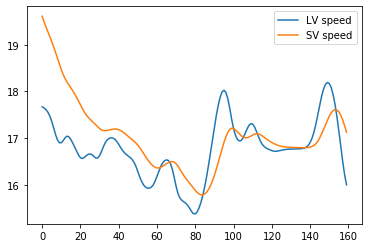

In [8]:
# speed
plt.plot(lv_spd, label ='LV speed')
plt.plot(traj[:,2], label ='SV speed')
plt.legend()

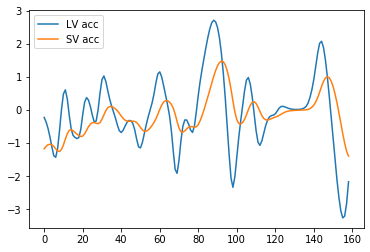

In [9]:
# acc
v_h = traj[:,2]
plt.plot(np.diff(lv_spd)/0.1, label = 'LV acc')
plt.plot(np.diff(v_h)/0.1, label = 'SV acc')
plt.legend()

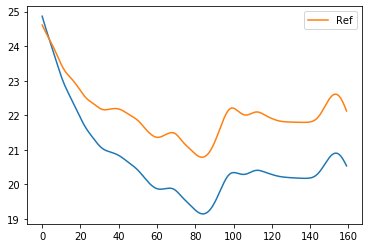

In [10]:
plt.plot(traj[:,0])
plt.plot(v_h*1+5, label = 'Ref')
plt.legend()

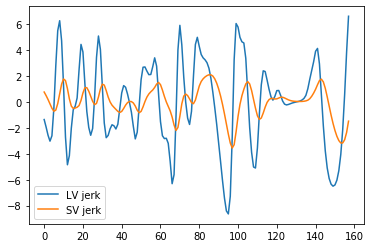

In [11]:
# jerk
v_h = traj[:,2]
acc_h = np.diff(v_h)/0.1
acc_lv = np.diff(lv_spd)/0.1
jerk_h = np.diff(acc_h)/0.1
jerk_lv = np.diff(acc_lv)/0.1
plt.plot(jerk_lv, label = 'LV jerk')
plt.plot(jerk_h, label = 'SV jerk')
plt.legend()